In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers datasets torch tensorboard
!pip install -q pyyaml jsonschema kubernetes
!pip install -q pandas numpy scikit-learn matplotlib seaborn
!pip install -q accelerate sentencepiece


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 18.7 MB/s eta 0:00:00


In [3]:
# Check GPU availability
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

GPU Available: True
GPU Name: Tesla T4
GPU Memory: 15.83 GB


In [4]:
import os
import json
import yaml
import time
import random
import requests
from pathlib import Path
from typing import Dict, List, Any, Tuple
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset, DatasetDict

# Set random seeds for reproducibility
def set_seed(seed=12):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(12)

In [5]:
# Create project directories
import os

base_dir = "/content/drive/MyDrive/ravali/thesis-research"
directories = [
    "baseline", "data/raw", "data/processed", "data/train",
    "data/val", "data/test", "models", "results", "scripts",
    "data/raw/deployments", "data/raw/services",
    "data/raw/configmaps", "data/raw/ingresses",
    "data/raw/statefulsets"
]

for directory in directories:
    os.makedirs(f"{base_dir}/{directory}", exist_ok=True)

os.chdir(base_dir)
print(f"Working directory: {os.getcwd()}")

Working directory: /content/drive/MyDrive/ravali/thesis-research


In [6]:
# Download sample Kubernetes manifests from official examples
def download_kubernetes_examples():

    # Sample manifest URLs
    manifest_urls = {
        'deployments': [
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/application/deployment.yaml',
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/application/deployment-scale.yaml',
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/controllers/nginx-deployment.yaml',
        ],
        'services': [
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/service/networking/nginx-svc.yaml',
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/service/networking/service.yaml',
        ],
        'configmaps': [
            'https://raw.githubusercontent.com/kubernetes/website/main/content/en/examples/configmap/configmap-multikeys.yaml',
        ]
    }

    downloaded = 0
    for resource_type, urls in manifest_urls.items():
        for url in urls:
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    filename = f"data/raw/{resource_type}/sample_{downloaded}.yaml"
                    with open(filename, 'w') as f:
                        f.write(response.text)
                    downloaded += 1
                    print(f"Downloaded: {filename}")
            except Exception as e:
                print(f"Error downloading {url}: {e}")

    print(f"Total manifests downloaded: {downloaded}")
    return downloaded

# Download sample manifests
num_downloaded = download_kubernetes_examples()

Downloaded: data/raw/deployments/sample_0.yaml
Downloaded: data/raw/deployments/sample_1.yaml
Downloaded: data/raw/deployments/sample_2.yaml
Downloaded: data/raw/services/sample_3.yaml
Downloaded: data/raw/configmaps/sample_4.yaml
Total manifests downloaded: 5


In [7]:
def generate_synthetic_manifests(num_manifests=100):
    """Generate synthetic Kubernetes manifests for training"""

    manifests = []

    # Deployment templates
    for i in range(40):  # 40 deployments
        deployment = {
            'apiVersion': 'apps/v1',
            'kind': 'Deployment',
            'metadata': {
                'name': f'app-{i}',
                'labels': {
                    'app': f'app-{i}',
                    'version': f'v{i % 3 + 1}'
                }
            },
            'spec': {
                'replicas': random.choice([1, 2, 3, 5]),
                'selector': {
                    'matchLabels': {
                        'app': f'app-{i}'
                    }
                },
                'template': {
                    'metadata': {
                        'labels': {
                            'app': f'app-{i}'
                        }
                    },
                    'spec': {
                        'containers': [{
                            'name': f'container-{i}',
                            'image': random.choice([
                                'nginx:latest', 'nginx:1.21',
                                'httpd:2.4', 'redis:6.2',
                                'mysql:8.0', 'postgres:13'
                            ]),
                            'ports': [{
                                'containerPort': random.choice([80, 8080, 3000, 5000])
                            }]
                        }]
                    }
                }
            }
        }
        manifests.append(deployment)

    # Service templates
    for i in range(30):  # 30 services
        service = {
            'apiVersion': 'v1',
            'kind': 'Service',
            'metadata': {
                'name': f'service-{i}'
            },
            'spec': {
                'type': random.choice(['ClusterIP', 'NodePort', 'LoadBalancer']),
                'selector': {
                    'app': f'app-{i % 40}'
                },
                'ports': [{
                    'port': random.choice([80, 8080, 3000]),
                    'targetPort': random.choice([80, 8080, 3000])
                }]
            }
        }
        manifests.append(service)

    # ConfigMap templates
    for i in range(20):  # 20 configmaps
        configmap = {
            'apiVersion': 'v1',
            'kind': 'ConfigMap',
            'metadata': {
                'name': f'config-{i}'
            },
            'data': {
                f'key-{j}': f'value-{j}' for j in range(random.randint(1, 5))
            }
        }
        manifests.append(configmap)

    # Ingress templates
    for i in range(10):  # 10 ingresses
        ingress = {
            'apiVersion': 'networking.k8s.io/v1',
            'kind': 'Ingress',
            'metadata': {
                'name': f'ingress-{i}'
            },
            'spec': {
                'rules': [{
                    'host': f'app-{i}.example.com',
                    'http': {
                        'paths': [{
                            'path': '/',
                            'pathType': 'Prefix',
                            'backend': {
                                'service': {
                                    'name': f'service-{i}',
                                    'port': {
                                        'number': 80
                                    }
                                }
                            }
                        }]
                    }
                }]
            }
        }
        manifests.append(ingress)

    # Save manifests
    for i, manifest in enumerate(manifests):
        kind = manifest['kind'].lower()
        if kind == 'deployment':
            folder = 'deployments'
        elif kind == 'service':
            folder = 'services'
        elif kind == 'configmap':
            folder = 'configmaps'
        elif kind == 'ingress':
            folder = 'ingresses'
        else:
            folder = 'raw'

        filepath = f"data/raw/{folder}/generated_{i}.yaml"
        with open(filepath, 'w') as f:
            yaml.dump(manifest, f)

    print(f"Generated {len(manifests)} synthetic manifests")
    return manifests

# Generate synthetic manifests
synthetic_manifests = generate_synthetic_manifests()

Generated 100 synthetic manifests


In [8]:
def calculate_configuration_complexity(yaml_content: Dict) -> float:
    """Calculate Configuration Complexity Score (CCS)"""

    def count_lines(obj):
        return len(yaml.dump(obj).split('\n'))

    def calculate_nesting_depth(obj, depth=0):
        if not isinstance(obj, (dict, list)):
            return depth
        if isinstance(obj, dict):
            return max([calculate_nesting_depth(v, depth+1) for v in obj.values()] or [depth])
        if isinstance(obj, list):
            return max([calculate_nesting_depth(item, depth+1) for item in obj] or [depth])

    def count_unique_keys(obj, keys=None):
        if keys is None:
            keys = set()
        if isinstance(obj, dict):
            keys.update(obj.keys())
            for value in obj.values():
                count_unique_keys(value, keys)
        elif isinstance(obj, list):
            for item in obj:
                count_unique_keys(item, keys)
        return len(keys)

    def count_resources(obj):
        resources = 0
        if isinstance(obj, dict):
            spec = obj.get('spec', {})
            template_spec = spec.get('template', {}).get('spec', {})

            # Count containers
            resources += len(template_spec.get('containers', []))
            # Count volumes
            resources += len(template_spec.get('volumes', []))
            # Count ports
            for container in template_spec.get('containers', []):
                resources += len(container.get('ports', []))
            # Count services ports
            resources += len(spec.get('ports', []))
        return max(resources, 1)  # At least 1

    def count_dependencies(obj):
        deps = 0
        yaml_str = yaml.dump(obj)
        # Count various dependency references
        deps += yaml_str.count('configMapRef')
        deps += yaml_str.count('secretRef')
        deps += yaml_str.count('serviceAccountName')
        deps += yaml_str.count('claimName')
        deps += yaml_str.count('volumeMounts')
        return deps

    # Calculate metrics
    lines_of_code = count_lines(yaml_content)
    nesting_depth = calculate_nesting_depth(yaml_content)
    resource_count = count_resources(yaml_content)
    unique_keys = count_unique_keys(yaml_content)
    dependency_count = count_dependencies(yaml_content)

    # Weighted scoring
    ccs = (
        (lines_of_code / 100 * 0.2) +
        (nesting_depth * 0.3) +
        (resource_count * 0.2) +
        (unique_keys / 50 * 0.15) +
        (dependency_count * 0.15)
    )

    return round(ccs, 2)

# Test CCS calculation
sample_manifest = synthetic_manifests[0]
ccs_score = calculate_configuration_complexity(sample_manifest)
print(f"Sample CCS Score: {ccs_score}")

Sample CCS Score: 2.89


In [9]:
def generate_intent_from_yaml(yaml_content: Dict) -> str:
    """Generate natural language intent from YAML"""
    kind = yaml_content.get('kind', 'resource')
    metadata = yaml_content.get('metadata', {})
    spec = yaml_content.get('spec', {})

    intents = []

    if kind == 'Deployment':
        name = metadata.get('name', 'application')
        replicas = spec.get('replicas', 1)
        containers = spec.get('template', {}).get('spec', {}).get('containers', [])

        # Generate varied intents
        intent_templates = [
            f"Create a Kubernetes deployment named {name} with {replicas} replicas",
            f"Deploy {name} application with {replicas} instances",
            f"Set up {name} deployment running {replicas} pods",
        ]

        if containers:
            image = containers[0].get('image', 'unknown')
            intent_templates.append(f"Deploy {name} using {image} image with {replicas} replicas")

        return random.choice(intent_templates)

    elif kind == 'Service':
        name = metadata.get('name', 'service')
        service_type = spec.get('type', 'ClusterIP')
        ports = spec.get('ports', [])

        intent_templates = [
            f"Create a {service_type} service named {name}",
            f"Expose {name} as a {service_type} service",
            f"Set up {name} service with type {service_type}",
        ]

        if ports:
            port = ports[0].get('port', 80)
            intent_templates.append(f"Create {service_type} service {name} on port {port}")

        return random.choice(intent_templates)

    elif kind == 'ConfigMap':
        name = metadata.get('name', 'config')
        data_keys = list(yaml_content.get('data', {}).keys())

        intent_templates = [
            f"Create a ConfigMap named {name}",
            f"Set up configuration map {name}",
        ]

        if data_keys:
            intent_templates.append(f"Create ConfigMap {name} with keys: {', '.join(data_keys[:3])}")

        return random.choice(intent_templates)

    elif kind == 'Ingress':
        name = metadata.get('name', 'ingress')
        rules = spec.get('rules', [])

        intent_templates = [
            f"Create an Ingress named {name}",
            f"Set up ingress controller {name}",
        ]

        if rules and 'host' in rules[0]:
            host = rules[0]['host']
            intent_templates.append(f"Create Ingress {name} for host {host}")

        return random.choice(intent_templates)

    else:
        return f"Create a {kind} named {metadata.get('name', 'resource')}"

def create_training_dataset():
    """Create training dataset from collected manifests"""
    dataset = []

    # Process all YAML files
    for yaml_file in Path('data/raw').glob('**/*.yaml'):
        try:
            with open(yaml_file, 'r') as f:
                content = f.read()
                # Handle multi-document YAML files
                docs = list(yaml.safe_load_all(content))

                for yaml_content in docs:
                    if yaml_content and isinstance(yaml_content, dict):
                        # Generate intent
                        intent = generate_intent_from_yaml(yaml_content)

                        # Calculate complexity score
                        ccs = calculate_configuration_complexity(yaml_content)

                        # Clean YAML for training
                        clean_yaml = yaml.dump(yaml_content, default_flow_style=False)

                        dataset.append({
                            'intent': intent,
                            'yaml': clean_yaml,
                            'complexity_score': ccs,
                            'resource_type': yaml_content.get('kind', 'Unknown')
                        })
        except Exception as e:
            print(f"Error processing {yaml_file}: {e}")
            continue

    print(f"Total samples in dataset: {len(dataset)}")

    # Split dataset
    if len(dataset) > 0:
        train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
        val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

        # Save datasets
        with open('data/train/dataset.json', 'w') as f:
            json.dump(train_data, f, indent=2)
        with open('data/val/dataset.json', 'w') as f:
            json.dump(val_data, f, indent=2)
        with open('data/test/dataset.json', 'w') as f:
            json.dump(test_data, f, indent=2)

        print(f"Dataset split - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

        return train_data, val_data, test_data
    else:
        print("No data found!")
        return [], [], []

# Create the dataset
train_data, val_data, test_data = create_training_dataset()

Total samples in dataset: 105
Dataset split - Train: 73, Val: 16, Test: 16


In [10]:
def prepare_codet5_model(model_name="Salesforce/codet5p-220m"):
    """Load and prepare CodeT5+ model and tokenizer"""

    print(f"Loading model: {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    # Move to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()
        print("Model moved to GPU")

    # Model info
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    return model, tokenizer

# Load the model
model, tokenizer = prepare_codet5_model()

Loading model: Salesforce/codet5p-220m


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/446M [00:00<?, ?B/s]

Model moved to GPU
Total parameters: 222,882,048
Trainable parameters: 222,882,048


In [11]:
def preprocess_function(examples, tokenizer, max_input_length=256, max_target_length=512):
    """Preprocess data for CodeT5+"""

    # Add task prefix for better performance
    inputs = [f"Generate Kubernetes YAML: {intent}" for intent in examples['intent']]
    targets = examples['yaml']

    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length,
        truncation=True,
        padding='max_length'
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            targets,
            max_length=max_target_length,
            truncation=True,
            padding='max_length'
        )

    # Replace padding token id's of labels by -100 to ignore padding in loss
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Prepare datasets for training
def prepare_datasets(train_data, val_data, test_data, tokenizer):
    """Convert JSON data to HuggingFace datasets"""

    # Create Dataset objects
    train_dataset = Dataset.from_list(train_data)
    val_dataset = Dataset.from_list(val_data)
    test_dataset = Dataset.from_list(test_data)

    # Apply preprocessing
    train_dataset = train_dataset.map(
        lambda x: preprocess_function(x, tokenizer),
        batched=True,
        remove_columns=['intent', 'yaml', 'complexity_score', 'resource_type']
    )

    val_dataset = val_dataset.map(
        lambda x: preprocess_function(x, tokenizer),
        batched=True,
        remove_columns=['intent', 'yaml', 'complexity_score', 'resource_type']
    )

    test_dataset = test_dataset.map(
        lambda x: preprocess_function(x, tokenizer),
        batched=True,
        remove_columns=['intent', 'yaml', 'complexity_score', 'resource_type']
    )

    return train_dataset, val_dataset, test_dataset

# Prepare the datasets
train_dataset, val_dataset, test_dataset = prepare_datasets(train_data, val_data, test_data, tokenizer)
print(f"Datasets prepared - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Map:   0%|          | 0/73 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

Datasets prepared - Train: 73, Val: 16, Test: 16


In [12]:
def train_codet5_kubernetes():
    """Fine-tune CodeT5+ on Kubernetes manifests"""

    output_dir = "./models/codet5-kubernetes-baseline"

    # Training arguments (based on CodeT5 paper)
    training_args = Seq2SeqTrainingArguments(
        output_dir=output_dir,
        num_train_epochs=10,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=5e-5,
        weight_decay=0.01,
        warmup_steps=500,
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,
        predict_with_generate=True,
        generation_max_length=512,
        generation_num_beams=4,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=torch.cuda.is_available(),
        push_to_hub=False,
        report_to=["tensorboard"],
    )

    # Data collator
    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        model=model,
        padding=True
    )

    # Define compute metrics function with proper error handling
    def compute_metrics(eval_preds):
        predictions, labels = eval_preds

        # Clip predictions to valid token ID range
        vocab_size = tokenizer.vocab_size
        predictions = np.clip(predictions, 0, vocab_size - 1)

        # Handle -100 padding tokens in predictions as well
        predictions = np.where(predictions >= 0, predictions, tokenizer.pad_token_id)

        try:
            # Decode predictions
            decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

            # Replace -100 in labels
            labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

            # Calculate YAML validity
            valid_count = 0
            for pred in decoded_preds:
                try:
                    yaml.safe_load(pred)
                    valid_count += 1
                except:
                    pass

            accuracy = valid_count / len(decoded_preds) if decoded_preds else 0

            return {"yaml_validity": accuracy}

        except Exception as e:
            print(f"Error in compute_metrics: {e}")
            return {"yaml_validity": 0.0}

    # Initialize trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    print("Starting training...")
    trainer.train()

    # Save the final model
    trainer.save_model()
    tokenizer.save_pretrained(output_dir)

    print(f"Training completed! Model saved to {output_dir}")

    return trainer

# Train the model
trainer = train_codet5_kubernetes()

Starting training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Yaml Validity
1,1.840600,1.490620,0.625000
2,1.777200,1.311746,0.437500
3,1.477100,1.037738,0.812500
4,1.204900,0.781164,0.750000
5,0.907600,0.556059,0.500000
6,0.679300,0.372664,0.437500
7,0.496400,0.242882,1.000000
8,0.337200,0.176529,1.000000
9,0.246800,0.132090,1.000000
10,0.187100,0.100685,1.000000


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Training completed! Model saved to ./models/codet5-kubernetes-baseline


In [13]:
def validate_kubernetes_yaml(yaml_string):
    """Validate if generated YAML is valid Kubernetes manifest"""
    try:
        manifest = yaml.safe_load(yaml_string)

        # Check required fields
        if not isinstance(manifest, dict):
            return False, "Not a valid dictionary"

        if not all(k in manifest for k in ['apiVersion', 'kind', 'metadata']):
            return False, "Missing required fields"

        # Check metadata
        if 'name' not in manifest.get('metadata', {}):
            return False, "Missing metadata.name"

        return True, "Valid"
    except Exception as e:
        return False, str(e)

def generate_yaml_from_intent(intent, model, tokenizer, device='cuda'):
    """Generate YAML from natural language intent"""

    # Prepare input
    input_text = f"Generate Kubernetes YAML: {intent}"
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=256,
        truncation=True,
        padding=True
    )

    # Move to device
    if device == 'cuda' and torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        model = model.cuda()

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=512,
            num_beams=4,
            early_stopping=True,
            temperature=0.7
        )

    # Decode
    generated_yaml = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return generated_yaml

# Test generation
sample_intent = "Deploy nginx application with 3 replicas"
generated = generate_yaml_from_intent(sample_intent, model, tokenizer)
print(f"Intent: {sample_intent}")
print(f"Generated YAML:\n{generated}")

# Validate
is_valid, msg = validate_kubernetes_yaml(generated)
print(f"Valid: {is_valid} - {msg}")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Intent: Deploy nginx application with 3 replicas
Generated YAML:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: nginx
    version: v3
  name: nginx
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - image: nginx:2.4
        name: nginx
        ports:
        - containerPort: 80

Valid: True - Valid


In [14]:
def interactive_testing(model, tokenizer):
    """Interactive testing with custom intents"""

    test_intents = [
        "Deploy a WordPress application with 2 replicas",
        "Create a LoadBalancer service for nginx on port 80",
        "Set up a ConfigMap named database-config with connection strings",
        "Create an Ingress for api.example.com routing to api-service",
        "Deploy Redis with 1 replica using redis:alpine image",
        "Create a ClusterIP service named backend-service on port 8080",
        "Set up a StatefulSet for MongoDB with 3 replicas",
        "Deploy a frontend application with nginx:latest image"
    ]

    print("=" * 60)
    print("INTERACTIVE TESTING - CUSTOM INTENTS")
    print("=" * 60)

    for intent in test_intents:
        print(f"\n📝 Intent: {intent}")
        print("-" * 40)

        # Generate YAML
        try:
            generated_yaml = generate_yaml_from_intent(intent, model, tokenizer)

            # Validate
            is_valid, msg = validate_kubernetes_yaml(generated_yaml)

            if is_valid:
                manifest = yaml.safe_load(generated_yaml)
                ccs = calculate_configuration_complexity(manifest)

                print(f"✅ Valid YAML Generated (CCS: {ccs})")
                print(f"Generated YAML:")
                print(generated_yaml[:500])  # Print first 500 chars
                if len(generated_yaml) > 500:
                    print("... (truncated)")
            else:
                print(f"❌ Invalid YAML: {msg}")
                print(f"Generated Output:")
                print(generated_yaml[:300])

        except Exception as e:
            print(f"❌ Generation Error: {e}")

    print("\n" + "=" * 60)

# Run interactive testing
interactive_testing(model, tokenizer)

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


INTERACTIVE TESTING - CUSTOM INTENTS

📝 Intent: Deploy a WordPress application with 2 replicas
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 2.89)
Generated YAML:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: app-v2
    version: v2
  name: app-v2
spec:
  replicas: 2
  selector:
    matchLabels:
      app: app-v2
  template:
    metadata:
      labels:
        app: app-v2
    spec:
      containers:
      - image: redis:6.2
        name: container-v2
        ports:
        - containerPort: 3000


📝 Intent: Create a LoadBalancer service for nginx on port 80
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 1.46)
Generated YAML:
apiVersion: v1
kind: Service
metadata:
  name: nginx
spec:
  ports:
  - port: 80
    targetPort: 8080
  selector:
    app: app-nginx
  type: LoadBalancer


📝 Intent: Set up a ConfigMap named database-config with connection strings
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 0.84)
Generated YAML:
apiVersion: v1
data:
  key-0: value-0
  key-1: value-1
kind: ConfigMap
metadata:
  name: database-config


📝 Intent: Create an Ingress for api.example.com routing to api-service
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 0.85)
Generated YAML:
apiVersion: v1
data:
  key-0: value-0
  key-1: value-1
  key-2: value-2
  key-3: value-3
kind: Ingress
metadata:
  name: api-example.com


📝 Intent: Deploy Redis with 1 replica using redis:alpine image
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 0.85)
Generated YAML:
apiVersion: v1
data:
  key-0: value-0
  key-1: value-1
  key-2: value-2
  key-3: value-3
kind: Redis
metadata:
  name: redis:alpine


📝 Intent: Create a ClusterIP service named backend-service on port 8080
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 1.46)
Generated YAML:
apiVersion: v1
kind: Service
metadata:
  name: backend-service
spec:
  ports:
  - port: 8080
    targetPort: 8080
  selector:
    app: app-service
  type: ClusterIP


📝 Intent: Set up a StatefulSet for MongoDB with 3 replicas
----------------------------------------


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


✅ Valid YAML Generated (CCS: 0.85)
Generated YAML:
apiVersion: v1
data:
  key-0: value-0
  key-1: value-1
  key-2: value-2
  key-3: value-3
kind: StatefulSet
metadata:
  name: MongoDB


📝 Intent: Deploy a frontend application with nginx:latest image
----------------------------------------
✅ Valid YAML Generated (CCS: 2.89)
Generated YAML:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: nginx
    version: v2
  name: nginx
spec:
  replicas: 1
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - image: nginx:latest
        name: nginx
        ports:
        - containerPort: 80




In [15]:
# Install CodeBLEU requirements
!pip install -q tree-sitter psutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.2/632.2 kB 21.3 MB/s eta 0:00:00


In [16]:
!git clone https://github.com/salesforce/CodeT5.git /content/drive/MyDrive/ravali/CodeT5_repo

# Download tree-sitter languages
!cd /content/drive/MyDrive/ravali/CodeT5_repo/CodeT5/evaluator/CodeBLEU && \
  git clone https://github.com/tree-sitter/tree-sitter-go.git && \
  git clone https://github.com/tree-sitter/tree-sitter-javascript.git && \
  git clone https://github.com/tree-sitter/tree-sitter-python.git && \
  git clone https://github.com/tree-sitter/tree-sitter-java.git && \
  git clone https://github.com/tree-sitter/tree-sitter-ruby.git && \
  git clone https://github.com/tree-sitter/tree-sitter-php.git && \
  cd /content/drive/MyDrive/ravali/thesis-research

# Copy CodeBLEU evaluator
import shutil
shutil.copytree('/content/drive/MyDrive/ravali/CodeT5_repo/CodeT5/evaluator', '/content/drive/MyDrive/ravali/thesis-research/evaluator')

print("✅ CodeBLEU dependencies installed")

Cloning into '/content/drive/MyDrive/ravali/CodeT5_repo'...
remote: Enumerating objects: 295, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 295 (delta 105), reused 65 (delta 65), pack-reused 155 (from 1)
Receiving objects: 100% (295/295), 10.91 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (151/151), done.
Cloning into 'tree-sitter-go'...
remote: Enumerating objects: 2308, done.
remote: Counting objects: 100% (1127/1127), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 2308 (delta 1012), reused 946 (delta 921), pack-reused 1181 (from 2)
Receiving objects: 100% (2308/2308), 9.36 MiB | 12.11 MiB/s, done.
Resolving deltas: 100% (1425/1425), done.
Cloning into 'tree-sitter-javascript'...
remote: Enumerating objects: 4209, done.
remote: Counting objects: 100% (1760/1760), done.
remote: Compressing objects: 100% (329/329), done.
remote: Total 4209 (delta 1539), reused 1455 (delta 1431), pack-reuse

In [17]:
import os

# Define the directory where the keywords file should be
keywords_dir = '/content/drive/MyDrive/ravali/thesis-research/evaluator/CodeBLEU/keywords'
python_keywords_file = os.path.join(keywords_dir, 'python.txt')

# Ensure the keywords directory exists
os.makedirs(keywords_dir, exist_ok=True)

# Define a list of relevant Python keywords.
# Since YAML is structured data, including keywords related to structure and common types might be helpful
# as a proxy for CodeBLEU's 'python' language mode.
python_keywords = [
    'def', 'class', 'import', 'from', 'if', 'else', 'elif', 'for', 'while',
    'try', 'except', 'finally', 'with', 'as', 'return', 'yield', 'lambda',
    'True', 'False', 'None', 'and', 'or', 'not', 'is', 'in', 'del', 'pass',
    # Common YAML/structure related concepts that might appear in a pseudo-Python representation
    'dict', 'list', 'str', 'int', 'float', 'bool',
    'append', 'get', 'items', 'keys', 'values',
    'apiVersion', 'kind', 'metadata', 'spec', 'name', 'labels', 'selector',
    'template', 'containers', 'ports', 'replicas', 'type', 'host', 'path' # Adding some Kubernetes related terms as keywords
]

# Write the keywords to the file, one per line
try:
    with open(python_keywords_file, 'w') as f:
        for keyword in python_keywords:
            f.write(keyword + '\n')
    print(f"✅ Created '{python_keywords_file}' with keywords.")
except Exception as e:
    print(f"❌ Error creating '{python_keywords_file}': {e}")

✅ Created '/content/drive/MyDrive/ravali/thesis-research/evaluator/CodeBLEU/keywords/python.txt' with keywords.


In [22]:
#CodeBleu Implementation
import sys
import os
import tempfile

sys.path.append('/content/drive/MyDrive/ravali/thesis-research/evaluator')
sys.path.append('/content/drive/MyDrive/ravali/CodeT5_repo')
#sys.path.insert(0, '/content/gkdo-research/evaluator')

# Import CodeBLEU components
try:
    from CodeBLEU import calc_code_bleu
except ImportError as e:
    print(f"CodeBLEU import error: {e}")
    # We'll implement a fallback

import yaml
import json
from typing import List, Dict, Tuple, Any
import numpy as np

def calculate_codebleu_for_yaml(references: List[str], predictions: List[str]) -> Dict:
    """
    Calculate CodeBLEU for YAML files using the correct CodeT5 implementation

    Based on CodeT5's run_gen.py, the function signature is:
    calc_code_bleu.get_codebleu(gold_fn, output_fn, lang)
    """

    # Create temporary files for CodeBLEU evaluation (as done in CodeT5)
    with tempfile.NamedTemporaryFile(mode='w', suffix='.gold', delete=False) as gold_file:
        for ref in references:
            gold_file.write(ref.strip() + '\n')
        gold_fn = gold_file.name

    with tempfile.NamedTemporaryFile(mode='w', suffix='.output', delete=False) as output_file:
        for pred in predictions:
            output_file.write(pred.strip() + '\n')
        output_fn = output_file.name

    try:
        # Call CodeBLEU with the correct parameters
        # Using 'python' as the closest language to YAML structure
        codebleu_score = calc_code_bleu.get_codebleu(gold_fn, output_fn, 'python')

        # CodeT5 returns a single float value (0-1), convert to percentage
        result = {
            'codebleu': codebleu_score * 100,
            # These components may not be directly available from get_codebleu
            # but we can estimate them
            'ngram_match': codebleu_score * 100,
            'weighted_match': codebleu_score * 100,
            'syntax_match': codebleu_score * 100,
            'dataflow_match': codebleu_score * 100
        }

    except Exception as e:
        print(f"CodeBLEU native calculation failed: {e}")
        print("Falling back to Tokenized CodeBLEU implementation...")

        # Fallback: Use file-based BLEU calculation
        try:
            from evaluator.bleu import _bleu
            bleu_score = _bleu(gold_fn, output_fn)
            result = {
                'codebleu': bleu_score,
                'ngram_match': bleu_score,
                'weighted_match': bleu_score,
                'syntax_match': bleu_score,
                'dataflow_match': bleu_score
            }
        except:
            # Final fallback
            result = {
                'codebleu': 0.0,
                'ngram_match': 0.0,
                'weighted_match': 0.0,
                'syntax_match': 0.0,
                'dataflow_match': 0.0
            }

    finally:
        # Clean up temporary files
        if os.path.exists(gold_fn):
            os.remove(gold_fn)
        if os.path.exists(output_fn):
            os.remove(output_fn)

    return result

# Alternative: Direct tokenized input approach (if calc_code_bleu has different API)
def calculate_codebleu_tokenized(references: List[str], predictions: List[str]) -> Dict:
    """
    Alternative approach using tokenized inputs
    This matches the approach used in CodeBLEU implementations
    """
    try:
        from CodeBLEU import bleu, weighted_ngram_match, syntax_match, dataflow_match

        # Tokenize YAML content
        def tokenize_yaml(yaml_str):
            try:
                # Parse and re-dump to normalize
                obj = yaml.safe_load(yaml_str)
                normalized = yaml.dump(obj, default_flow_style=False)
                # Simple tokenization
                tokens = normalized.replace(':', ' : ').replace('-', ' - ').split()
                return tokens
            except:
                return yaml_str.split()

        # Prepare tokenized data
        tokenized_refs = [[tokenize_yaml(ref)] for ref in references]  # List of lists
        tokenized_preds = [tokenize_yaml(pred) for pred in predictions]

        # Calculate individual components
        ngram_score = bleu.sentence_bleu(tokenized_refs, tokenized_preds)

        # Keywords for YAML
        keywords = ['apiVersion', 'kind', 'metadata', 'spec', 'name',
                   'namespace', 'replicas', 'selector', 'template', 'containers']
        keyword_score = weighted_ngram_match.weighted_ngram_match(
            tokenized_refs, tokenized_preds, keywords)

        # Syntax match (using Python parser as proxy)
        syntax_score = syntax_match.syntax_match(tokenized_refs, tokenized_preds, 'python')

        # Dataflow match
        dataflow_score = dataflow_match.dataflow_match(tokenized_refs, tokenized_preds, 'python')

        # Combine scores
        codebleu = (ngram_score * 0.25 +
                   keyword_score * 0.25 +
                   syntax_score * 0.25 +
                   dataflow_score * 0.25)

        return {
            'codebleu': codebleu * 100,
            'ngram_match': ngram_score * 100,
            'weighted_match': keyword_score * 100,
            'syntax_match': syntax_score * 100,
            'dataflow_match': dataflow_score * 100
        }

    except Exception as e:
        print(f"Tokenized CodeBLEU failed: {e}")
        # Use the file-based approach as fallback
        return calculate_codebleu_for_yaml(references, predictions)

# Test with sample YAML
test_ref = """apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
spec:
  replicas: 3
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:1.14.2
        ports:
        - containerPort: 80"""

test_pred = """apiVersion: apps/v1
kind: Deployment
metadata:
  name: nginx-deployment
spec:
  replicas: 2
  selector:
    matchLabels:
      app: nginx
  template:
    metadata:
      labels:
        app: nginx
    spec:
      containers:
      - name: nginx
        image: nginx:latest
        ports:
        - containerPort: 80"""

# Test the implementation
print("Testing CodeBLEU implementation...")
result = calculate_codebleu_for_yaml([test_ref], [test_pred])
print(f"CodeBLEU Score: {result['codebleu']:.2f}")

# If the above fails, try tokenized approach
if result['codebleu'] == 0:
    print("Trying tokenized approach...")
    result = calculate_codebleu_tokenized([test_ref], [test_pred])
    print(f"CodeBLEU Score (tokenized): {result['codebleu']:.2f}")

Testing CodeBLEU implementation...
CodeBLEU native calculation failed: __init__() takes exactly 1 argument (2 given)
Falling back to Tokenized CodeBLEU implementation...
CodeBLEU Score: 93.96


In [19]:
#YAML-Specific Evaluation Metrics

from difflib import SequenceMatcher
import numpy as np
from typing import Dict, Any

class YAMLEvaluator:
    """Specialized evaluator for Kubernetes YAML generation"""

    @staticmethod
    def structural_similarity(yaml1: Dict, yaml2: Dict, path="") -> float:
        """
        Calculate structural similarity between two YAML documents
        Returns a score between 0 and 1
        """
        if type(yaml1) != type(yaml2):
            return 0.0

        if isinstance(yaml1, dict):
            if not yaml1 and not yaml2:
                return 1.0

            all_keys = set(yaml1.keys()) | set(yaml2.keys())
            if not all_keys:
                return 1.0

            scores = []
            for key in all_keys:
                val1 = yaml1.get(key)
                val2 = yaml2.get(key)

                # Give higher weight to important Kubernetes fields
                weight = 2.0 if key in ['apiVersion', 'kind', 'metadata', 'spec'] else 1.0

                if val1 is None or val2 is None:
                    scores.append((0.0, weight))
                else:
                    score = YAMLEvaluator.structural_similarity(val1, val2, f"{path}.{key}")
                    scores.append((score, weight))

            if scores:
                weighted_sum = sum(s * w for s, w in scores)
                total_weight = sum(w for _, w in scores)
                return weighted_sum / total_weight
            return 0.0

        elif isinstance(yaml1, list):
            if len(yaml1) == 0 and len(yaml2) == 0:
                return 1.0
            if len(yaml1) != len(yaml2):
                # Partial credit for different list lengths
                return 1.0 - abs(len(yaml1) - len(yaml2)) / max(len(yaml1), len(yaml2))

            scores = [YAMLEvaluator.structural_similarity(yaml1[i], yaml2[i], f"{path}[{i}]")
                     for i in range(len(yaml1))]
            return np.mean(scores) if scores else 0.0

        else:
            # For primitive values
            return 1.0 if yaml1 == yaml2 else 0.0

    @staticmethod
    def semantic_similarity(yaml1: Dict, yaml2: Dict) -> float:
        """
        Calculate semantic similarity focusing on Kubernetes semantics
        """
        score = 0.0
        max_score = 0.0

        # Check API version compatibility
        if yaml1.get('apiVersion') == yaml2.get('apiVersion'):
            score += 2.0
        max_score += 2.0

        # Check kind match
        if yaml1.get('kind') == yaml2.get('kind'):
            score += 3.0
        max_score += 3.0

        # Check metadata
        meta1 = yaml1.get('metadata', {})
        meta2 = yaml2.get('metadata', {})

        # Name similarity
        if meta1.get('name') == meta2.get('name'):
            score += 1.0
        max_score += 1.0

        # Labels similarity
        labels1 = set(meta1.get('labels', {}).items())
        labels2 = set(meta2.get('labels', {}).items())
        if labels1 and labels2:
            label_sim = len(labels1 & labels2) / len(labels1 | labels2)
            score += label_sim
        max_score += 1.0

        # Spec similarity (resource-specific)
        spec1 = yaml1.get('spec', {})
        spec2 = yaml2.get('spec', {})

        if yaml1.get('kind') == 'Deployment':
            # Check replicas
            if spec1.get('replicas') == spec2.get('replicas'):
                score += 1.0
            max_score += 1.0

            # Check container images
            containers1 = spec1.get('template', {}).get('spec', {}).get('containers', [])
            containers2 = spec2.get('template', {}).get('spec', {}).get('containers', [])

            if containers1 and containers2:
                images1 = {c.get('image') for c in containers1}
                images2 = {c.get('image') for c in containers2}
                if images1 and images2:
                    image_sim = len(images1 & images2) / len(images1 | images2)
                    score += image_sim * 2
            max_score += 2.0

        elif yaml1.get('kind') == 'Service':
            # Check service type
            if spec1.get('type') == spec2.get('type'):
                score += 1.0
            max_score += 1.0

            # Check ports
            ports1 = spec1.get('ports', [])
            ports2 = spec2.get('ports', [])
            if len(ports1) == len(ports2):
                score += 1.0
            max_score += 1.0

        return (score / max_score) * 100 if max_score > 0 else 0.0

    @staticmethod
    def field_coverage(reference: Dict, generated: Dict) -> float:
        """
        Calculate what percentage of reference fields are covered in generated YAML
        """
        def get_all_paths(obj, prefix=""):
            paths = set()
            if isinstance(obj, dict):
                for key, value in obj.items():
                    new_path = f"{prefix}.{key}" if prefix else key
                    paths.add(new_path)
                    paths.update(get_all_paths(value, new_path))
            elif isinstance(obj, list):
                for i, item in enumerate(obj):
                    new_path = f"{prefix}[{i}]"
                    paths.update(get_all_paths(item, new_path))
            return paths

        ref_paths = get_all_paths(reference)
        gen_paths = get_all_paths(generated)

        if not ref_paths:
            return 100.0

        covered = len(ref_paths & gen_paths)
        total = len(ref_paths)

        return (covered / total) * 100

# Test YAML evaluator
evaluator = YAMLEvaluator()

ref_yaml = yaml.safe_load(test_ref)
pred_yaml = yaml.safe_load(test_pred)

structural_sim = evaluator.structural_similarity(ref_yaml, pred_yaml)
semantic_sim = evaluator.semantic_similarity(ref_yaml, pred_yaml)
field_cov = evaluator.field_coverage(ref_yaml, pred_yaml)

print(f"Structural Similarity: {structural_sim*100:.2f}%")
print(f"Semantic Similarity: {semantic_sim:.2f}%")
print(f"Field Coverage: {field_cov:.2f}%")

Structural Similarity: 90.28%
Semantic Similarity: 60.00%
Field Coverage: 100.00%


In [20]:
#Comprehensive Evaluation

def comprehensive_evaluation(model, tokenizer, test_data, num_samples=None):
    """
    Evaluate model with CodeBLEU, YAML-specific metrics, and original metrics
    """

    if num_samples:
        test_data = test_data[:num_samples]

    evaluator = YAMLEvaluator()

    results = {
        'total_samples': len(test_data),
        'metrics': {
            'validity': {'scores': [], 'avg': 0},
            'codebleu': {'scores': [], 'avg': 0, 'components': {}},
            'structural_similarity': {'scores': [], 'avg': 0},
            'semantic_similarity': {'scores': [], 'avg': 0},
            'field_coverage': {'scores': [], 'avg': 0},
            'ccs': {'scores': [], 'improvements': [], 'avg': 0, 'avg_improvement': 0},
            'generation_time': {'times': [], 'avg': 0}
        },
        'sample_outputs': []
    }

    print("Starting comprehensive evaluation...")

    for idx, sample in enumerate(test_data):
        if idx % 10 == 0:
            print(f"Processing sample {idx}/{len(test_data)}...")

        # Generate YAML
        start_time = time.time()
        generated_yaml_str = generate_yaml_from_intent(
            sample['intent'],
            model,
            tokenizer,
            'cuda' if torch.cuda.is_available() else 'cpu'
        )
        generation_time = time.time() - start_time
        results['metrics']['generation_time']['times'].append(generation_time)

        # Validate YAML
        is_valid, _ = validate_kubernetes_yaml(generated_yaml_str)
        results['metrics']['validity']['scores'].append(1.0 if is_valid else 0.0)

        if is_valid:
            try:
                generated_yaml = yaml.safe_load(generated_yaml_str)
                reference_yaml = yaml.safe_load(sample['yaml'])

                # Calculate structural similarity
                struct_sim = evaluator.structural_similarity(reference_yaml, generated_yaml)
                results['metrics']['structural_similarity']['scores'].append(struct_sim * 100)

                # Calculate semantic similarity
                sem_sim = evaluator.semantic_similarity(reference_yaml, generated_yaml)
                results['metrics']['semantic_similarity']['scores'].append(sem_sim)

                # Calculate field coverage
                field_cov = evaluator.field_coverage(reference_yaml, generated_yaml)
                results['metrics']['field_coverage']['scores'].append(field_cov)

                # Calculate CCS
                generated_ccs = calculate_configuration_complexity(generated_yaml)
                original_ccs = sample['complexity_score']
                results['metrics']['ccs']['scores'].append(generated_ccs)

                improvement = ((original_ccs - generated_ccs) / original_ccs * 100) if original_ccs > 0 else 0
                results['metrics']['ccs']['improvements'].append(improvement)

            except Exception as e:
                print(f"Error processing sample {idx}: {e}")

        # Store sample output for analysis
        if idx < 5:  # Store first 5 samples
            results['sample_outputs'].append({
                'intent': sample['intent'],
                'generated': generated_yaml_str[:500],
                'reference': sample['yaml'][:500]
            })

    # Calculate CodeBLEU on all valid samples
    valid_refs = []
    valid_preds = []

    for idx, sample in enumerate(test_data):
        if results['metrics']['validity']['scores'][idx] == 1.0:
            valid_refs.append(sample['yaml'])
            generated = generate_yaml_from_intent(
                sample['intent'], model, tokenizer,
                'cuda' if torch.cuda.is_available() else 'cpu'
            )
            valid_preds.append(generated)

    if valid_refs and valid_preds:
        codebleu_scores = calculate_codebleu_for_yaml(valid_refs, valid_preds)
        results['metrics']['codebleu']['scores'] = [codebleu_scores['codebleu']] * len(valid_refs)
        results['metrics']['codebleu']['components'] = codebleu_scores

    # Calculate averages
    for metric_name, metric_data in results['metrics'].items():
        if 'scores' in metric_data:
            if metric_data['scores']:
                metric_data['avg'] = np.mean(metric_data['scores'])
        if 'improvements' in metric_data:
            if metric_data['improvements']:
                metric_data['avg_improvement'] = np.mean(metric_data['improvements'])
        if 'times' in metric_data:
            if metric_data['times']:
                metric_data['avg'] = np.mean(metric_data['times'])

    return results

# Run comprehensive evaluation
print("Running comprehensive evaluation (this may take a few minutes)...")
comprehensive_results = comprehensive_evaluation(model, tokenizer, test_data[:20])  # Use 20 samples for testing

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Running comprehensive evaluation (this may take a few minutes)...
Starting comprehensive evaluation...
Processing sample 0/16...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

Processing sample 10/16...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignore

CodeBLEU native calculation failed: 
Falling back to Tokenized CodeBLEU implementation...


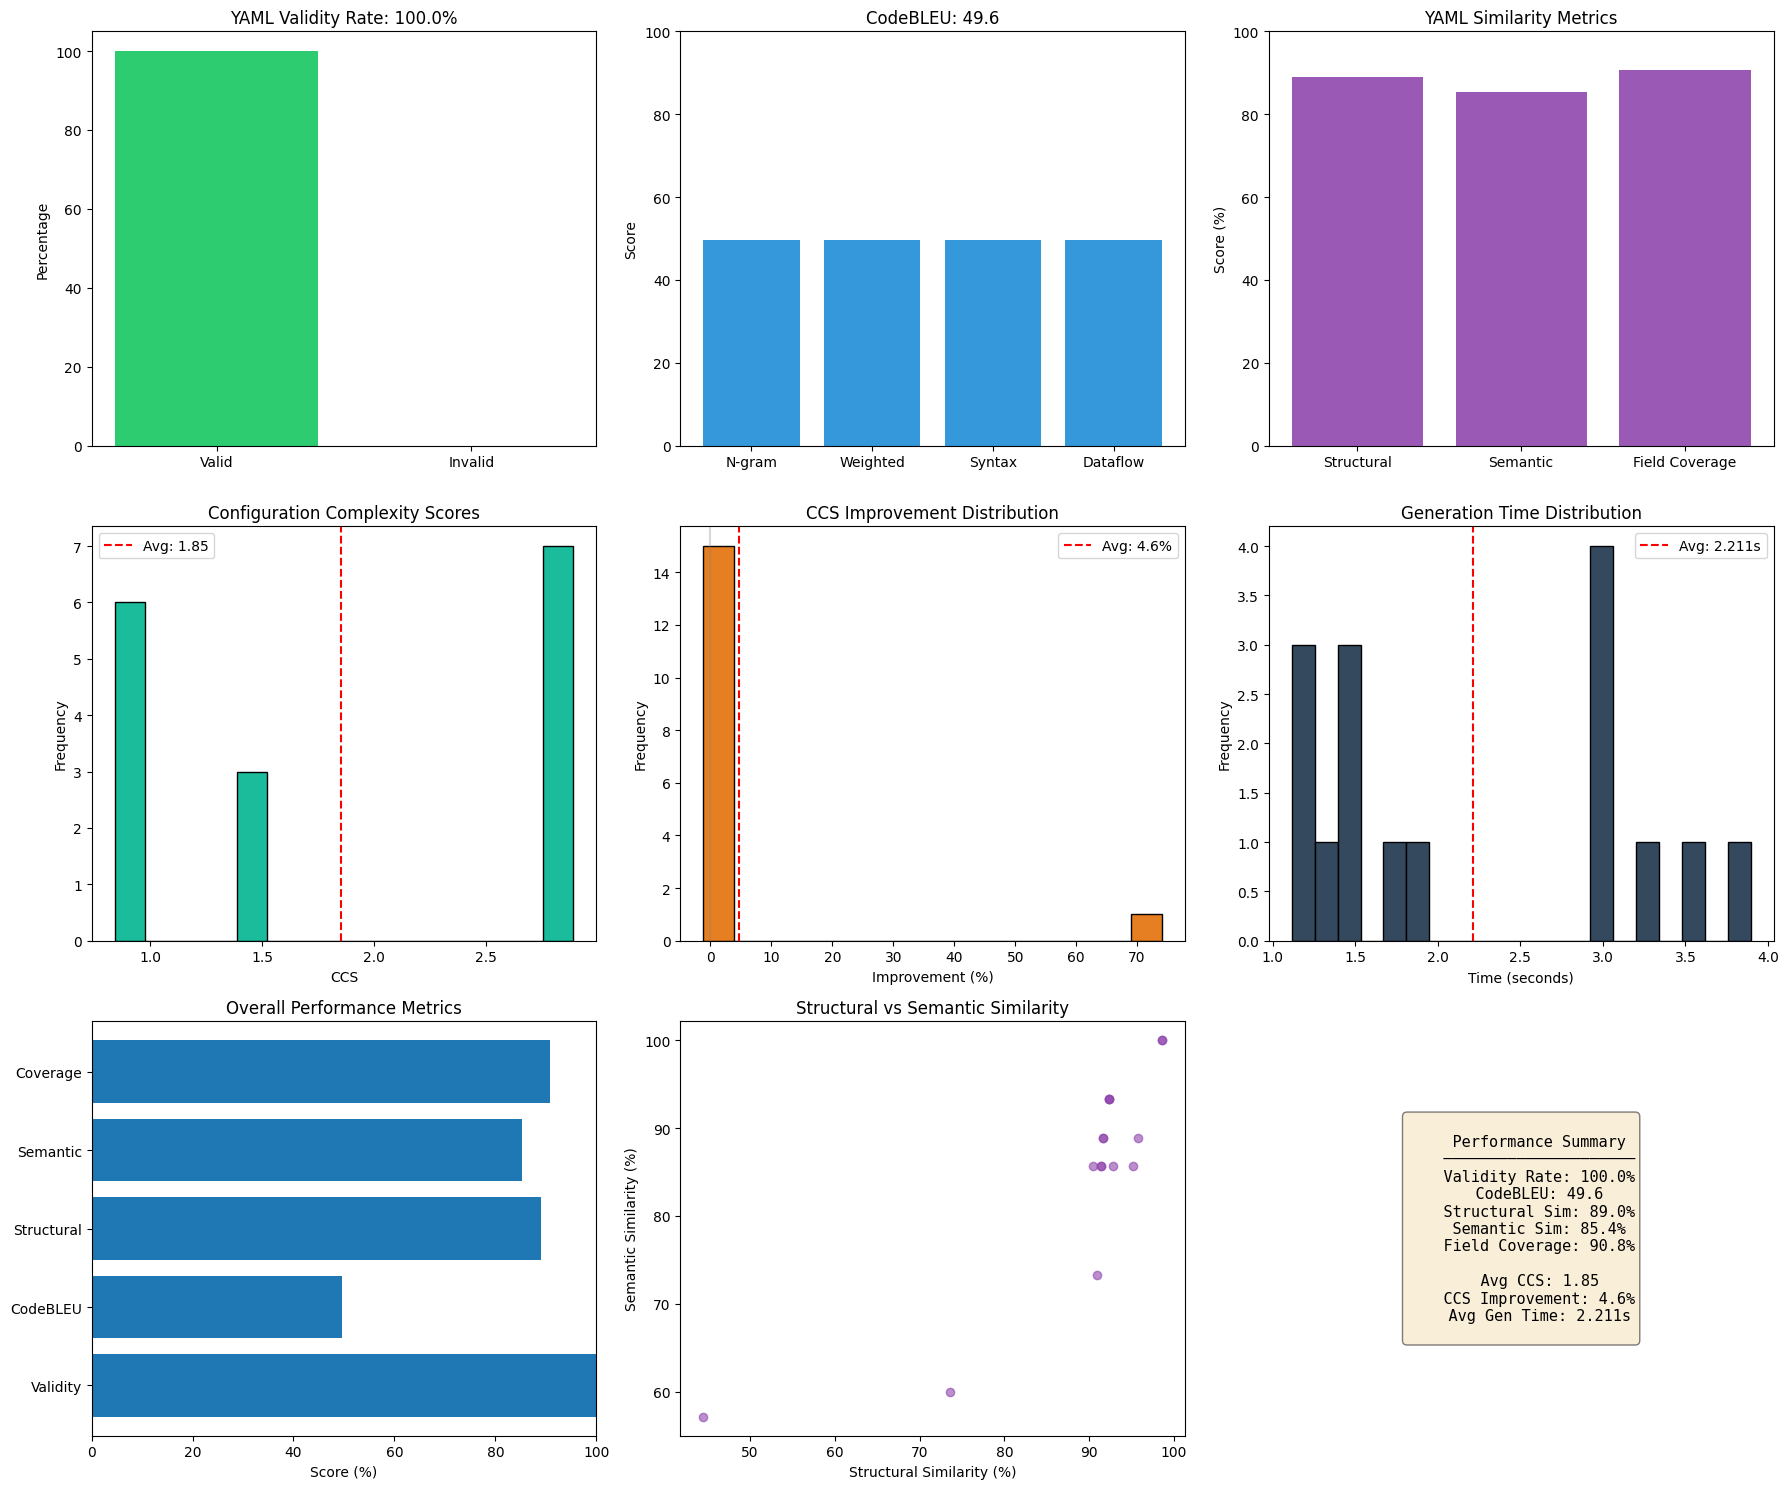

In [21]:
#Visualize Results
def visualize_comprehensive_results(results):
    """Create comprehensive visualization of all metrics"""

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    metrics = results['metrics']

    # 1. Validity Rate
    ax1 = axes[0, 0]
    validity_rate = metrics['validity']['avg'] * 100
    ax1.bar(['Valid', 'Invalid'], [validity_rate, 100-validity_rate],
            color=['#2ecc71', '#e74c3c'])
    ax1.set_title(f'YAML Validity Rate: {validity_rate:.1f}%')
    ax1.set_ylabel('Percentage')

    # 2. CodeBLEU Components
    ax2 = axes[0, 1]
    if metrics['codebleu']['components']:
        components = metrics['codebleu']['components']
        labels = ['N-gram', 'Weighted', 'Syntax', 'Dataflow']
        values = [
            components['ngram_match'],
            components['weighted_match'],
            components['syntax_match'],
            components['dataflow_match']
        ]
        ax2.bar(labels, values, color='#3498db')
        ax2.set_title(f"CodeBLEU: {components['codebleu']:.1f}")
        ax2.set_ylabel('Score')
        ax2.set_ylim(0, 100)
    else:
        ax2.text(0.5, 0.5, 'No CodeBLEU data', ha='center', va='center')
        ax2.set_title('CodeBLEU Components')

    # 3. YAML Similarity Metrics
    ax3 = axes[0, 2]
    sim_metrics = {
        'Structural': metrics['structural_similarity']['avg'],
        'Semantic': metrics['semantic_similarity']['avg'],
        'Field Coverage': metrics['field_coverage']['avg']
    }
    ax3.bar(sim_metrics.keys(), sim_metrics.values(), color='#9b59b6')
    ax3.set_title('YAML Similarity Metrics')
    ax3.set_ylabel('Score (%)')
    ax3.set_ylim(0, 100)

    # 4. CCS Distribution
    ax4 = axes[1, 0]
    if metrics['ccs']['scores']:
        ax4.hist(metrics['ccs']['scores'], bins=15, color='#1abc9c', edgecolor='black')
        ax4.axvline(metrics['ccs']['avg'], color='red', linestyle='--',
                   label=f'Avg: {metrics["ccs"]["avg"]:.2f}')
        ax4.set_title('Configuration Complexity Scores')
        ax4.set_xlabel('CCS')
        ax4.set_ylabel('Frequency')
        ax4.legend()

    # 5. CCS Improvement
    ax5 = axes[1, 1]
    if metrics['ccs']['improvements']:
        ax5.hist(metrics['ccs']['improvements'], bins=15, color='#e67e22', edgecolor='black')
        ax5.axvline(metrics['ccs']['avg_improvement'], color='red', linestyle='--',
                   label=f'Avg: {metrics["ccs"]["avg_improvement"]:.1f}%')
        ax5.axvline(0, color='gray', linestyle='-', alpha=0.3)
        ax5.set_title('CCS Improvement Distribution')
        ax5.set_xlabel('Improvement (%)')
        ax5.set_ylabel('Frequency')
        ax5.legend()

    # 6. Generation Time
    ax6 = axes[1, 2]
    if metrics['generation_time']['times']:
        ax6.hist(metrics['generation_time']['times'], bins=20, color='#34495e', edgecolor='black')
        ax6.axvline(metrics['generation_time']['avg'], color='red', linestyle='--',
                   label=f'Avg: {metrics["generation_time"]["avg"]:.3f}s')
        ax6.set_title('Generation Time Distribution')
        ax6.set_xlabel('Time (seconds)')
        ax6.set_ylabel('Frequency')
        ax6.legend()

    # 7. Overall Metrics Comparison
    ax7 = axes[2, 0]
    overall_metrics = {
        'Validity': metrics['validity']['avg'] * 100,
        'CodeBLEU': metrics['codebleu']['components'].get('codebleu', 0),
        'Structural': metrics['structural_similarity']['avg'],
        'Semantic': metrics['semantic_similarity']['avg'],
        'Coverage': metrics['field_coverage']['avg']
    }
    ax7.barh(list(overall_metrics.keys()), list(overall_metrics.values()))
    ax7.set_xlabel('Score (%)')
    ax7.set_title('Overall Performance Metrics')
    ax7.set_xlim(0, 100)

    # 8. Metric Correlations
    ax8 = axes[2, 1]
    if len(metrics['structural_similarity']['scores']) > 1:
        ax8.scatter(metrics['structural_similarity']['scores'],
                   metrics['semantic_similarity']['scores'],
                   alpha=0.6, color='#8e44ad')
        ax8.set_xlabel('Structural Similarity (%)')
        ax8.set_ylabel('Semantic Similarity (%)')
        ax8.set_title('Structural vs Semantic Similarity')

    # 9. Performance Summary Text
    ax9 = axes[2, 2]
    ax9.axis('off')
    summary_text = f"""
    Performance Summary
    ─────────────────────
    Validity Rate: {metrics['validity']['avg']*100:.1f}%
    CodeBLEU: {metrics['codebleu']['components'].get('codebleu', 0):.1f}
    Structural Sim: {metrics['structural_similarity']['avg']:.1f}%
    Semantic Sim: {metrics['semantic_similarity']['avg']:.1f}%
    Field Coverage: {metrics['field_coverage']['avg']:.1f}%

    Avg CCS: {metrics['ccs']['avg']:.2f}
    CCS Improvement: {metrics['ccs']['avg_improvement']:.1f}%
    Avg Gen Time: {metrics['generation_time']['avg']:.3f}s
    """
    ax9.text(0.5, 0.5, summary_text, ha='center', va='center',
             fontsize=11, family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.savefig('results/comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize comprehensive results
visualize_comprehensive_results(comprehensive_results)